In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from scipy.signal import find_peaks
import os

# File path to your CSV data
DATA_FILE_PATH = '/kaggle/input/tap-data/Gandhinagar/accelerometer_data.csv' 

# Load the data
def load_data(file_path):
    """Load accelerometer data from CSV file"""
    print(f"Loading data from: {file_path}")
    try:
        
        data = pd.read_csv(file_path, delimiter=' ')
        
        if len(data.columns) == 1:  
            print("Retrying with comma delimiter...")
            data = pd.read_csv(file_path, delimiter=',')
        
        expected_columns = ['TapDetected', 'AccX', 'AccY', 'AccZ']
        if not all(col in data.columns for col in expected_columns):
            if len(data.columns) == 4:  
                print("Renaming columns to expected format...")
                data.columns = expected_columns
    
        print(f"Data loaded successfully. Shape: {data.shape}")
        print(f"Columns: {data.columns.tolist()}")
        print(f"First few rows:\n{data.head()}")
        
        return data
    
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Please check your file path and format.")
        raise


In [9]:
# Feature extraction
def extract_features(data, window_size=5):
    """Extract features from accelerometer data using sliding window approach"""
    print(f"Extracting features with window size {window_size}...")
    features = []
    labels = []
    
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i+window_size]
        
        # Extract features from window
        acc_x_mean = window['AccX'].mean()
        acc_y_mean = window['AccY'].mean()
        acc_z_mean = window['AccZ'].mean()
        
        acc_x_std = window['AccX'].std()
        acc_y_std = window['AccY'].std()
        acc_z_std = window['AccZ'].std()
        
        acc_x_max = window['AccX'].max()
        acc_y_max = window['AccY'].max()
        acc_z_max = window['AccZ'].max()
        
        acc_x_min = window['AccX'].min()
        acc_y_min = window['AccY'].min()
        acc_z_min = window['AccZ'].min()
        
        # Calculate magnitude
        magnitude = np.sqrt(window['AccX']**2 + window['AccY']**2 + window['AccZ']**2).mean()
        magnitude_std = np.sqrt(window['AccX']**2 + window['AccY']**2 + window['AccZ']**2).std()
        
        # Combine features
        feature_vector = [
            acc_x_mean, acc_y_mean, acc_z_mean,
            acc_x_std, acc_y_std, acc_z_std,
            acc_x_max, acc_y_max, acc_z_max,
            acc_x_min, acc_y_min, acc_z_min,
            magnitude, magnitude_std
        ]
        
        features.append(feature_vector)
        
        # Label is the most common value in the TapDetected column of the window
        label = window['TapDetected'].mode().iloc[0]
        labels.append(label)
    
    print(f"Extracted {len(features)} feature vectors")
    return np.array(features), np.array(labels)


In [10]:
# Plot accelerometer data
def plot_data(data):
    """Plot accelerometer data and highlight tap events"""
    print("Plotting accelerometer data...")
    
    plt.figure(figsize=(14, 10))
    
    # Plot X, Y, Z accelerations
    plt.subplot(4, 1, 1)
    plt.plot(data['AccX'], label='X-axis')
    plt.plot(data['AccY'], label='Y-axis')
    plt.plot(data['AccZ'], label='Z-axis')
    plt.legend()
    plt.title('Accelerometer Data')
    plt.ylabel('Acceleration (g)')
    
    # Plot magnitude
    plt.subplot(4, 1, 2)
    magnitude = np.sqrt(data['AccX']**2 + data['AccY']**2 + data['AccZ']**2)
    plt.plot(magnitude, label='Magnitude')
    plt.legend()
    plt.title('Acceleration Magnitude')
    plt.ylabel('Magnitude (g)')
    
    # Plot tap events
    plt.subplot(4, 1, 3)
    plt.stem(data['TapDetected'], linefmt='r-', markerfmt='ro', basefmt='r-')
    plt.title('Tap Events (Ground Truth)')
    plt.ylabel('Tap Detected')
    
    # Find peaks in magnitude for comparison
    # Adjust height and distance parameters based on your data
    try:
        mean_mag = magnitude.mean()
        std_mag = magnitude.std()
        height_threshold = mean_mag + 1.5 * std_mag  # Adjust this threshold as needed
        
        peaks, _ = find_peaks(magnitude, height=height_threshold, distance=5)
        
        plt.subplot(4, 1, 4)
        plt.plot(magnitude)
        plt.plot(peaks, magnitude[peaks], "x")
        plt.title(f'Peak Detection Analysis (Threshold: {height_threshold:.2f})')
        plt.ylabel('Magnitude (g)')
        plt.xlabel('Sample')
    except Exception as e:
        print(f"Warning: Peak detection failed - {e}")
        plt.subplot(4, 1, 4)
        plt.plot(magnitude)
        plt.title('Magnitude (Peak detection failed)')
        plt.ylabel('Magnitude (g)')
        plt.xlabel('Sample')
    
    plt.tight_layout()
    
    # Save plot
    output_dir = 'output'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'accelerometer_data_analysis.png'))
    plt.show()


In [11]:
# Train ML model
def train_model(features, labels):
    """Train a RandomForest classifier for tap detection"""
    print("Training machine learning model...")
    
    # Check if we have enough data
    if len(features) < 10:
        print("Warning: Very small dataset. Results may not be reliable.")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.3, random_state=42, stratify=labels
    )
    
    print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Model Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Tap', 'Tap'], 
                yticklabels=['No Tap', 'Tap'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Tap Detection Confusion Matrix')
    plt.savefig(os.path.join('output', 'confusion_matrix.png'))
    plt.show()
    
    return model


In [ ]:
# Real-time tap detection simulation
def simulate_real_time_detection(data, model, window_size=5):
    """Simulate real-time tap detection on data"""
    print("Simulating real-time tap detection...")
    
    detected_taps = []
    consecutive_detections = 0
    cooldown = 0
    cooldown_period = 5  # Samples to wait after a detection before detecting again
    
    for i in range(len(data) - window_size + 1):
        if cooldown > 0:
            cooldown -= 1
            continue
            
        window = data.iloc[i:i+window_size]
        
        # Extract features from the current window
        acc_x_mean = window['AccX'].mean()
        acc_y_mean = window['AccY'].mean()
        acc_z_mean = window['AccZ'].mean()
        
        acc_x_std = window['AccX'].std()
        acc_y_std = window['AccY'].std()
        acc_z_std = window['AccZ'].std()
        
        acc_x_max = window['AccX'].max()
        acc_y_max = window['AccY'].max()
        acc_z_max = window['AccZ'].max()
        
        acc_x_min = window['AccX'].min()
        acc_y_min = window['AccY'].min()
        acc_z_min = window['AccZ'].min()
        
        magnitude = np.sqrt(window['AccX']**2 + window['AccY']**2 + window['AccZ']**2).mean()
        magnitude_std = np.sqrt(window['AccX']**2 + window['AccY']**2 + window['AccZ']**2).std()
        
        feature_vector = [
            acc_x_mean, acc_y_mean, acc_z_mean,
            acc_x_std, acc_y_std, acc_z_std,
            acc_x_max, acc_y_max, acc_z_max,
            acc_x_min, acc_y_min, acc_z_min,
            magnitude, magnitude_std
        ]
        
        # Predict using the model
        prediction = model.predict([feature_vector])[0]
        
        if prediction == 1:
            if consecutive_detections == 0:
                print(f"Tap detected at sample {i}!")
                detected_taps.append(i)
                cooldown = cooldown_period
            consecutive_detections += 1
        else:
            consecutive_detections = 0
    
    print(f"Total taps detected: {len(detected_taps)}")
    return detected_taps


In [12]:

# Feature importance analysis
def analyze_feature_importance(model, feature_names):
    """Analyze and visualize feature importance"""
    print("Analyzing feature importance...")
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance for Tap Detection')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join('output', 'feature_importance.png'))
    plt.show()
    
    # Print feature importance ranking
    print("\nFeature Importance Ranking:")
    for i in range(len(importances)):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


In [13]:

# Plot detection results
def plot_detection_results(data, detected_taps):
    """Plot the results of tap detection"""
    print("Plotting detection results...")
    
    plt.figure(figsize=(14, 8))
    
    # Plot magnitude
    magnitude = np.sqrt(data['AccX']**2 + data['AccY']**2 + data['AccZ']**2)
    plt.plot(magnitude, label='Magnitude', alpha=0.7)
    
    # Plot ground truth taps
    tap_indices = data.index[data['TapDetected'] == 1].tolist()
    plt.scatter(tap_indices, [magnitude[i] for i in tap_indices], color='red', label='Actual Taps', zorder=3)
    
    # Plot detected taps
    valid_detected_taps = [i for i in detected_taps if i < len(magnitude)]
    plt.scatter(valid_detected_taps, [magnitude[i] for i in valid_detected_taps], 
                color='green', marker='x', s=100, label='Detected Taps', zorder=3)
    
    plt.legend()
    plt.title('Tap Detection Results')
    plt.xlabel('Sample')
    plt.ylabel('Acceleration Magnitude (g)')
    plt.savefig(os.path.join('output', 'tap_detection_results.png'))
    plt.show()
    
    # Calculate detection metrics
    if tap_indices:
        true_positives = sum(1 for tap in valid_detected_taps if min([abs(tap - true_tap) for true_tap in tap_indices]) <= 5)
        false_positives = len(valid_detected_taps) - true_positives
        false_negatives = sum(1 for true_tap in tap_indices if min([abs(true_tap - tap) for tap in valid_detected_taps]) > 5)
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print("\nDetection Performance:")
        print(f"True Positives: {true_positives}")
        print(f"False Positives: {false_positives}")
        print(f"False Negatives: {false_negatives}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")


In [14]:

# Save model and results
def save_results(model, data, detected_taps):
    """Save model, processed data, and detection results"""
    print("Saving results...")
    
    output_dir = 'output'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save detection results
    results = pd.DataFrame({
        'Sample': range(len(data)),
        'AccX': data['AccX'],
        'AccY': data['AccY'],
        'AccZ': data['AccZ'],
        'Magnitude': np.sqrt(data['AccX']**2 + data['AccY']**2 + data['AccZ']**2),
        'TapDetected_Actual': data['TapDetected'],
        'TapDetected_Predicted': np.zeros(len(data))
    })
    
    # Mark predicted taps
    for tap in detected_taps:
        if tap < len(results):
            results.loc[tap, 'TapDetected_Predicted'] = 1
    
    results.to_csv(os.path.join(output_dir, 'detection_results.csv'), index=False)
    
    # Save processing summary
    with open(os.path.join(output_dir, 'processing_summary.txt'), 'w') as f:
        f.write("Accelerometer Tap Detection Summary\n")
        f.write("==================================\n\n")
        f.write(f"Data file: {DATA_FILE_PATH}\n")
        f.write(f"Total samples: {len(data)}\n")
        f.write(f"Actual taps: {data['TapDetected'].sum()}\n")
        f.write(f"Detected taps: {len(detected_taps)}\n\n")
        
        # Calculate some statistics
        magnitude = np.sqrt(data['AccX']**2 + data['AccY']**2 + data['AccZ']**2)
        f.write(f"Acceleration statistics:\n")
        f.write(f"  X-axis - Min: {data['AccX'].min():.2f}, Max: {data['AccX'].max():.2f}, Mean: {data['AccX'].mean():.2f}, StdDev: {data['AccX'].std():.2f}\n")
        f.write(f"  Y-axis - Min: {data['AccY'].min():.2f}, Max: {data['AccY'].max():.2f}, Mean: {data['AccY'].mean():.2f}, StdDev: {data['AccY'].std():.2f}\n")
        f.write(f"  Z-axis - Min: {data['AccZ'].min():.2f}, Max: {data['AccZ'].max():.2f}, Mean: {data['AccZ'].mean():.2f}, StdDev: {data['AccZ'].std():.2f}\n")
        f.write(f"  Magnitude - Min: {magnitude.min():.2f}, Max: {magnitude.max():.2f}, Mean: {magnitude.mean():.2f}, StdDev: {magnitude.std():.2f}\n")
    
    print(f"Results saved to {output_dir} directory")


ACCELEROMETER TAP DETECTION SYSTEM
Data file set to: /kaggle/input/tap-data/Gandhinagar/accelerometer_data.csv
To use a different data file, change the DATA_FILE_PATH variable at the top of the script.

1. LOADING DATA
--------------
Loading data from: /kaggle/input/tap-data/Gandhinagar/accelerometer_data.csv
Retrying with comma delimiter...
Data loaded successfully. Shape: (600, 5)
Columns: ['Timestamp', 'TapDetected', 'AccX', 'AccY', 'AccZ']
First few rows:
                    Timestamp  TapDetected   AccX   AccY   AccZ
0  2025-03-01 08:33:41.085189            1  0.835  0.962  9.899
1  2025-03-01 08:33:41.368189            0 -0.260 -0.228  9.559
2  2025-03-01 08:33:41.657189            0 -0.500  0.358  9.971
3  2025-03-01 08:33:41.988189            0  0.395  0.436  9.616
4  2025-03-01 08:33:42.168189            1  0.856  1.350  9.536

2. VISUALIZING DATA
------------------
Plotting accelerometer data...


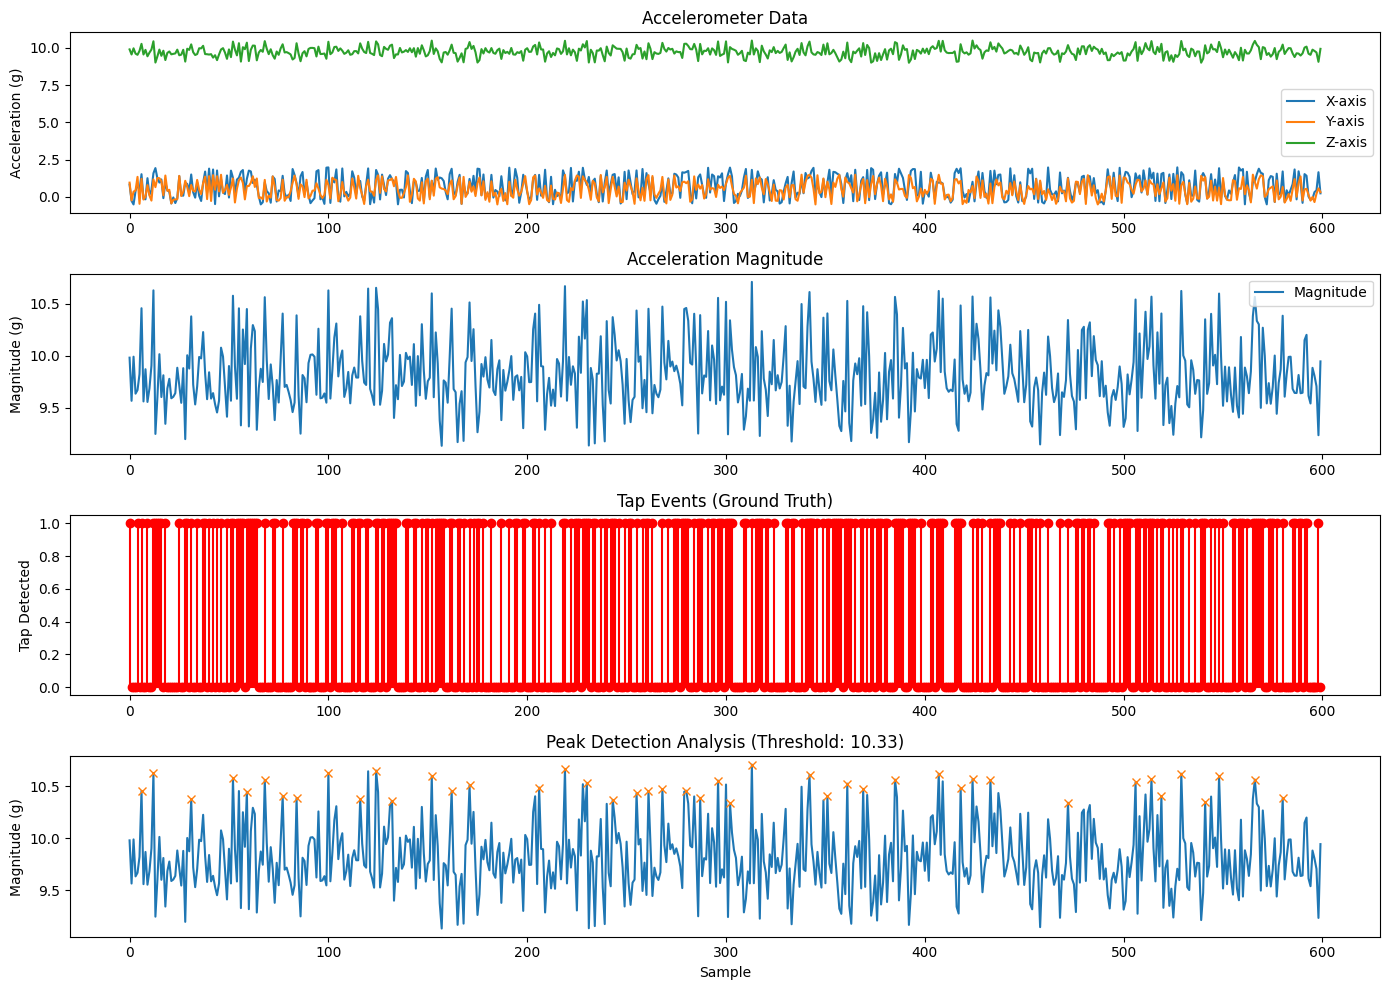


3. FEATURE EXTRACTION
--------------------
Extracting features with window size 5...
Extracted 596 feature vectors

4. MODEL TRAINING
----------------
Training machine learning model...
Training set size: 417, Test set size: 179
Model Accuracy: 0.9497

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        90
           1       0.97      0.93      0.95        89

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179



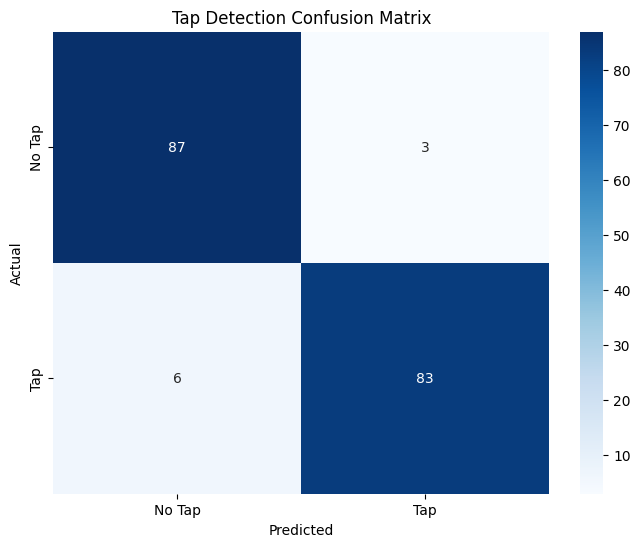


5. FEATURE IMPORTANCE ANALYSIS
-----------------------------
Analyzing feature importance...


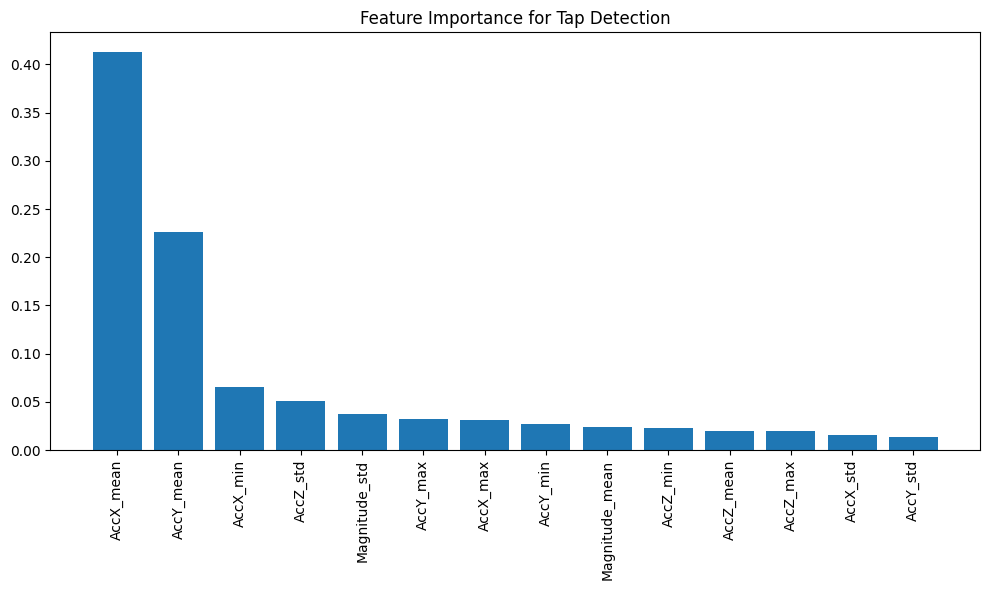


Feature Importance Ranking:
1. AccX_mean: 0.4125
2. AccY_mean: 0.2266
3. AccX_min: 0.0659
4. AccZ_std: 0.0510
5. Magnitude_std: 0.0379
6. AccY_max: 0.0323
7. AccX_max: 0.0312
8. AccY_min: 0.0271
9. Magnitude_mean: 0.0235
10. AccZ_min: 0.0229
11. AccZ_mean: 0.0196
12. AccZ_max: 0.0195
13. AccX_std: 0.0158
14. AccY_std: 0.0141

6. SIMULATED REAL-TIME DETECTION
-------------------------------
Simulating real-time tap detection...
Tap detected at sample 9!
Tap detected at sample 25!
Tap detected at sample 34!
Tap detected at sample 42!
Tap detected at sample 80!
Tap detected at sample 98!
Tap detected at sample 111!
Tap detected at sample 123!
Tap detected at sample 139!
Tap detected at sample 146!
Tap detected at sample 161!
Tap detected at sample 171!
Tap detected at sample 191!
Tap detected at sample 202!
Tap detected at sample 218!
Tap detected at sample 233!
Tap detected at sample 248!
Tap detected at sample 257!
Tap detected at sample 271!
Tap detected at sample 284!
Tap detected at

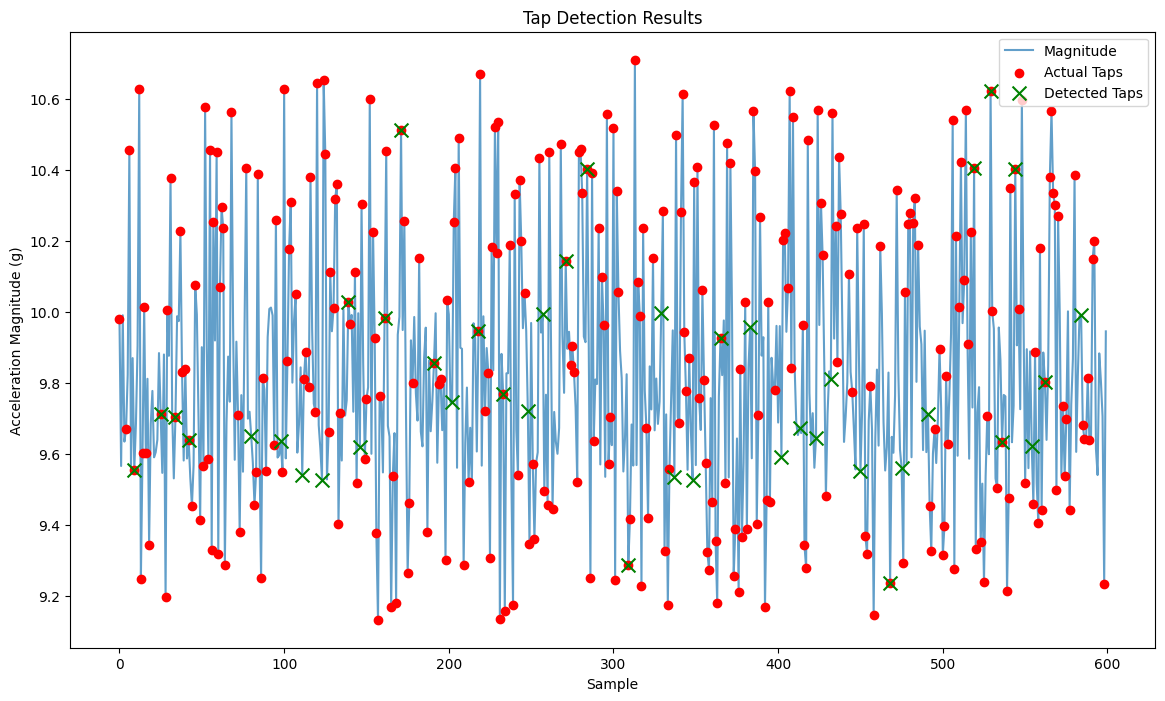


Detection Performance:
True Positives: 41
False Positives: 0
False Negatives: 103
Precision: 1.0000
Recall: 0.2847
F1 Score: 0.4432

8. SAVING RESULTS
----------------
Saving results...
Results saved to output directory

Tap detection analysis complete!
All results and visualizations saved to the 'output' directory


In [15]:
# Main function
def main():
    try:
        # Create output directory
        os.makedirs('output', exist_ok=True)
        
        # Load data
        print("\n1. LOADING DATA")
        print("--------------")
        data = load_data(DATA_FILE_PATH)
        
        # Plot the raw data
        print("\n2. VISUALIZING DATA")
        print("------------------")
        plot_data(data)
        
        # Extract features
        print("\n3. FEATURE EXTRACTION")
        print("--------------------")
        feature_names = [
            'AccX_mean', 'AccY_mean', 'AccZ_mean',
            'AccX_std', 'AccY_std', 'AccZ_std',
            'AccX_max', 'AccY_max', 'AccZ_max',
            'AccX_min', 'AccY_min', 'AccZ_min',
            'Magnitude_mean', 'Magnitude_std'
        ]
        features, labels = extract_features(data)
        
        # Train model
        print("\n4. MODEL TRAINING")
        print("----------------")
        model = train_model(features, labels)
        
        # Analyze feature importance
        print("\n5. FEATURE IMPORTANCE ANALYSIS")
        print("-----------------------------")
        analyze_feature_importance(model, feature_names)
        
        # Simulate real-time detection
        print("\n6. SIMULATED REAL-TIME DETECTION")
        print("-------------------------------")
        detected_taps = simulate_real_time_detection(data, model)
        
        # Plot results of real-time detection
        print("\n7. DETECTION RESULTS VISUALIZATION")
        print("---------------------------------")
        plot_detection_results(data, detected_taps)
        
        # Save results
        print("\n8. SAVING RESULTS")
        print("----------------")
        save_results(model, data, detected_taps)
        
        print("\nTap detection analysis complete!")
        print(f"All results and visualizations saved to the 'output' directory")
        
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
        print("\nPlease check your data file and try again.")

if __name__ == "__main__":
    print("=" * 80)
    print("ACCELEROMETER TAP DETECTION SYSTEM")
    print("=" * 80)
    print(f"Data file set to: {DATA_FILE_PATH}")
    print("To use a different data file, change the DATA_FILE_PATH variable at the top of the script.")
    print("=" * 80)
    main()